## PINN for 2D heat equation

#### Defining the problem:
$$\frac{d}{dt}u(x,y,t)=\alpha\left(\frac{d^2}{dx^2} + \frac{d^2}{dy^2}\right)u(x,y,t)$$

$$(x,y)\in[0,1]^2$$

Initial and boundary conditions:

$$u(x,0) = \sin(\pi x)\sin(2\pi y)$$

$$u(0,y,t) = u(1,y,t) = u(x,0,t) = u(x,1,t) =0$$

#### Boundary conditions are enforced with a hard constraint:
* Model is defined as $u_\theta(x,t)=16x(1-x)y(1-y)g_\theta(x,y,t)$
* $g_\theta(x,y,t)$ is a multilayer perceptron with parameters $\theta$.

In [1]:
import torch
from model_architecture import PINN
import matplotlib.pyplot as plt
from math import pi

alpha = 0.05  # Thermal diffusivity

# Loading model with trained weights
model = PINN()
model.load_state_dict(torch.load('weights1.pth'))
model.eval()

PINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [2]:
# Exact solution
def exact_solution(x, y, t):
    return torch.sin(pi*x) * torch.sin(2*pi*y) * torch.exp(-5*alpha*pi**2*t)

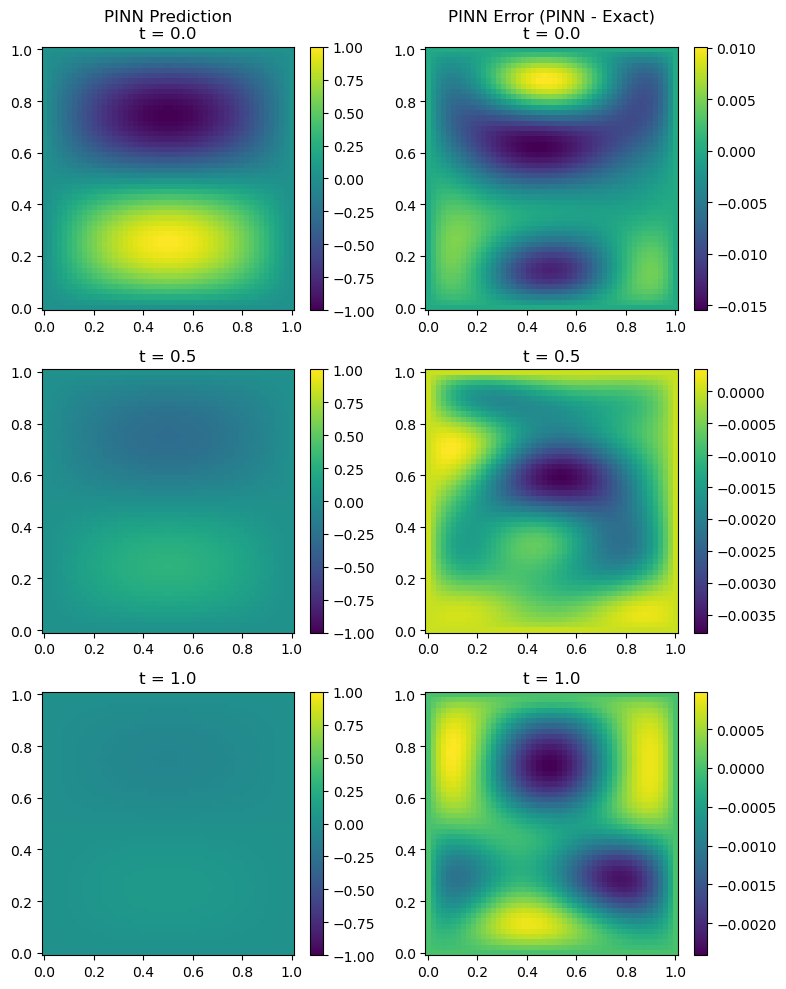

In [3]:
# Plot PINN solution and error

x_eval = torch.linspace(0, 1, 50)
y_eval = torch.linspace(0, 1, 50)
t_eval = torch.tensor([0.0, 0.5, 1.0])

X, Y = torch.meshgrid(x_eval, y_eval, indexing='ij')

fig, axes = plt.subplots(len(t_eval), 2, figsize=(8, 10))
for i, t in enumerate(t_eval):
    T = t * torch.ones_like(X)
    with torch.no_grad():
        U = model(X.reshape(-1, 1), Y.reshape(-1, 1), T.reshape(-1, 1)).reshape(X.shape)
    
    im = axes[i, 0].pcolormesh(X, Y, U, vmin=-1, vmax=1)
    axes[i, 0].set_title(f't = {t.item():.1f}')
    fig.colorbar(im, ax=axes[i, 0])

    U_exact = exact_solution(X, Y, T)
    im = axes[i, 1].pcolormesh(X, Y, U-U_exact)#, vmin=-.005, vmax=.005)
    axes[i, 1].set_title(f't = {t.item():.1f}')
    fig.colorbar(im, ax=axes[i, 1])

axes[0,0].set_title('PINN Prediction\nt = 0.0')
axes[0,1].set_title('PINN Error (PINN - Exact)\nt = 0.0')
plt.tight_layout()

### PINN errors are less than 1\%